In [1]:
import os, sys
import h5py
import numpy as np

import matplotlib.pyplot as plt

import logging


save_dir_name = 'climaX_2_ObsNoise'
diffs = np.load('../data/climaX_ObsNoise/diffs.npy')
#save_dir_name = 'climaX_ObsNoise_randLocs'
#diffs = np.load('../data/climaX_ObsNoise_randLocs/diffs.npy')

save_dir = '/eagle/MDClimSim/mjp5595/data/{}/'.format(save_dir_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#filepath = "/eagle/MDClimSim/awikner/irga_1415_test1_obs.hdf5" # Old Observations
#filepath = "/eagle/MDClimSim/mjp5595/ml4dvar/igra_141520_stormer_obs_standardized.hdf5"
#filepath = "/eagle/MDClimSim/mjp5595/ml4dvar/igra_141520_stormer_obs_standardized_360.hdf5"
filepath = "/eagle/MDClimSim/mjp5595/ml4dvar/igra_141520_stormer_obs_standardized_360_2.hdf5"

means = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_mean.npz')
stds = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_std.npz')

background_file_np = '/eagle/MDClimSim/mjp5595/ml4dvar/background_starter.npy' # This is just to initialize the model background

from vars_climaX import vars_climaX
vars_climax = vars_climaX().vars_climax

background_f = np.load(background_file_np, 'r')
print('background_f.shape :',background_f.shape)

noise_levels = [0, 0.01, 0.1, 1, 10, 100, 1000]

background_f.shape : (1, 82, 128, 256)


In [ ]:
from matplotlib import colors

# Plotting the results
forecast_step = 2
lon = np.linspace(0,360,256)
lat = np.linspace(90,-90,128)

#fig, axs = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (15,10))
fig, axs = plt.subplots(3, 3, figsize = (15,10))

# Get original forecast
hf = h5py.File(os.path.join(save_dir, 'forecast_noise{}.h5'.format(noise_levels[0])),'r')
forecast_orig = hf[str(forecast_step-1)]
axs[0, 0].invert_yaxis()
pc_orig = axs[0, 0].pcolormesh(lon, lat, forecast_orig[0], cmap = 'viridis')
#plt.colorbar(pc_orig, ax = axs[0,0], label='K')
axs[0, 0].set_title('Unperturbed Forecast')

perturbations = diffs[0,0]
cmap = colors.ListedColormap(['blue','white','red'])
bounds = [-1.5,-0.5,0.5,1.5]
axs[0, 1].invert_yaxis()
perts = axs[0, 1].pcolormesh(lon, lat, perturbations, cmap=cmap)
axs[0, 1].set_title('Perturbation sign/locations')

# get analysis and mse of perturbed forecasts
noise_mses = {}
for idx,noise_level in enumerate(noise_levels[1:]):
    print('Plotting noise level :',noise_level)
    hf = h5py.File(os.path.join(save_dir, 'forecast_noise{}.h5'.format(noise_level)),'r')
    forecast_perturbed = hf[str(forecast_step-1)]

    increment = forecast_perturbed[0] - forecast_orig[0]
    mse = np.mean(np.square(increment))
    noise_mses[noise_level] = mse

    axs[1+idx//3, idx%3].invert_yaxis()
    perts = axs[1+idx//3, idx%3].pcolormesh(lon, lat, np.log(increment), cmap='viridis')
    axs[1+idx//3, idx%3].set_title('Increment w/ Perturbation={}'.format(noise_level))


axs[0, 2]._shared_y_axes.remove(axs[0, 2])
axs[0, 2]._shared_x_axes.remove(axs[0, 2])
axs[0, 2].set_yscale('log')
axs[0, 2].set_title('MSE vs Perturbation Level')
#mse_arr = np.zeros(len(noise_mses))
mse_arr = []
print('mse_arr :',mse_arr)
print('noise_mses :',noise_mses)
noise_levels_str = []
for idx,noise_level in enumerate(noise_levels[1:]):
    mse_arr.append(noise_mses[noise_level])
    noise_levels_str.append(str(noise_level))
print('mse_arr :',mse_arr)
#mse_scat = axs[0, 2].scatter(noise_levels[1:],mse_arr)
#mse_scat = axs[0, 2].bar(np.arange(len(noise_levels[1:])),noise_levels[1:],legend=mse_arr)
#mse_scat = axs[0, 2].bar(np.arange(len(noise_levels[1:])),noise_levels[1:])
mse_scat = axs[0, 2].bar(noise_levels_str,mse_arr)
#axs[0, 2].set_xlabel(noise_levels[1:])

plt.suptitle('Effects of Perturbations on 12hr Forecast')
#plt.savefig('../data/climaX_ObsNoise/perturb.png')



In [2]:
def unstandardizeForecast(forecast, means=None, stds=None, climax_vars=None):
    if means is None:
        raise ValueError('Means is not defined and has not been input.')
    if stds is None:
        raise ValueError('Stds is not defined and has not been input.')
    if means is not None:
        means_array = np.zeros(len(climax_vars))
        for i, var in enumerate(climax_vars):
            val = means[var][0]
            means_array[i] = val
        means = means_array
    if stds is not None:
        stds_array = np.zeros(len(climax_vars))
        for i, var in enumerate(climax_vars):
            stds_array[i] = stds[var][0]
        stds = stds_array
    #forecasts_unstandardized = forecasts * stds.reshape(1, 1, -1, 1, 1) + \
    #                           means.reshape(1, 1, -1, 1, 1)
    # forecasts -> (forecast_steps,vars,lat,lon)
    forecasts_unstandardized = np.zeros_like(forecast)
    for i in range(len(means)):
        forecasts_unstandardized[i,:,:] = forecast[i,:,:] * stds[i]
        forecasts_unstandardized[i,:,:] = forecasts_unstandardized[i,:,:] + means[i]
    return forecasts_unstandardized

forecast_orig.shape : (82, 128, 256)
Plotting noise level : 0.01


/tmp/ipykernel_121555/922751509.py:54: RuntimeWarning: divide by zero encountered in log
  inc_min = min(inc_min,np.min(np.log(abs(increment))))
/tmp/ipykernel_121555/922751509.py:55: RuntimeWarning: divide by zero encountered in log
  inc_max = max(inc_max,np.max(np.log(abs(increment))))


Plotting noise level : 0.1
Plotting noise level : 1
Plotting noise level : 10
Plotting noise level : 100
Plotting noise level : 1000
Plotting noise level : 0.01
Plotting noise level : 0.1
Plotting noise level : 1
Plotting noise level : 10
Plotting noise level : 100
Plotting noise level : 1000
mse_arr : []
noise_mses : {0.01: 4.418836404011872, 0.1: 444.278315781473, 1: 20451.572376888544, 10: 68337.1317332674, 100: 45336.77546414892, 1000: 41087.466734498674}
mse_arr : [4.418836404011872, 444.278315781473, 20451.572376888544, 68337.1317332674, 45336.77546414892, 41087.466734498674]


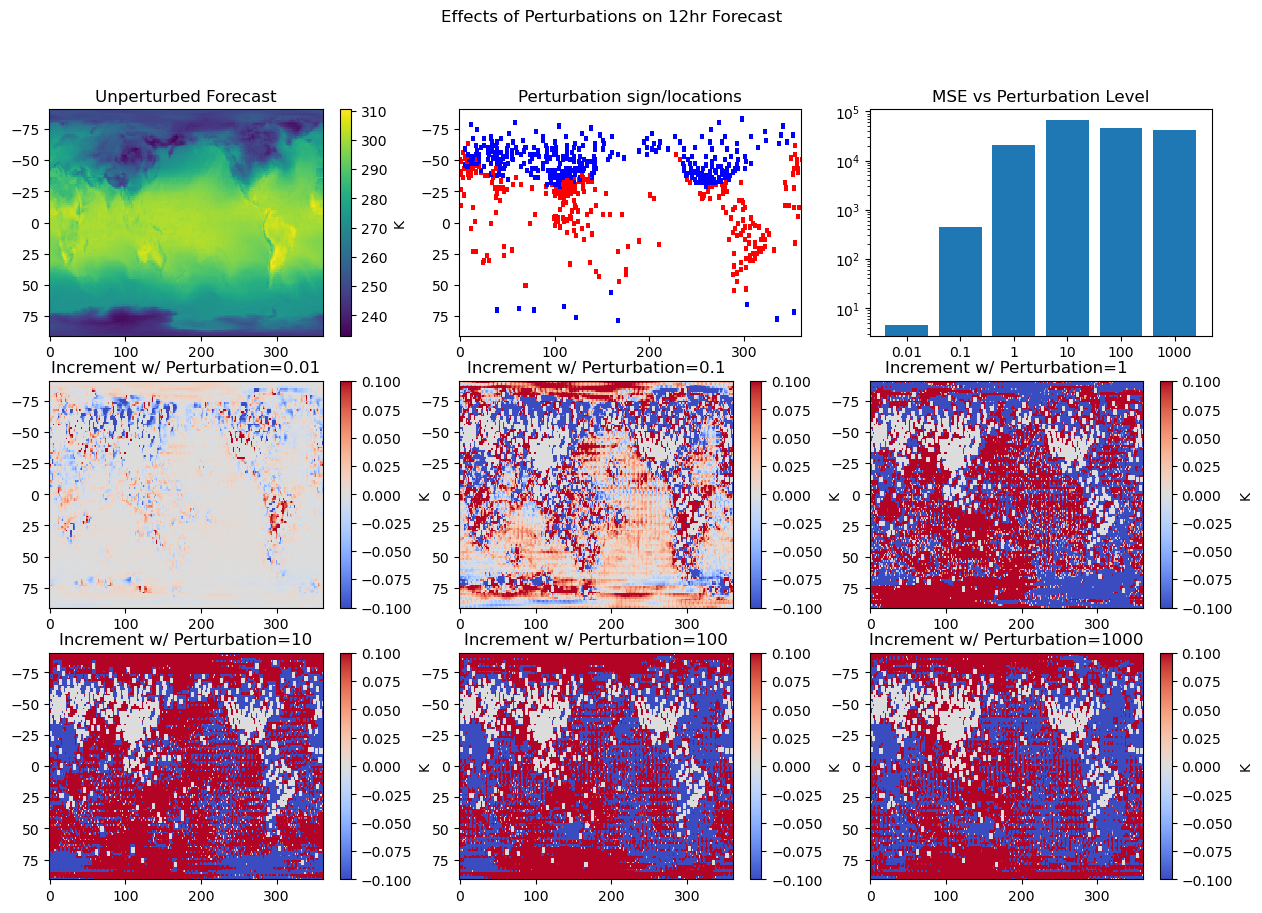

In [3]:
from matplotlib import colors
from matplotlib import cm

means = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_mean.npz')
stds = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_std.npz')

# Plotting the results
forecast_step = 2
lon = np.linspace(0,360,256)
lat = np.linspace(90,-90,128)

#fig, axs = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (15,10))
#fig, axs = plt.subplots(3, 3, figsize = (15,10))
fig = plt.figure(figsize=(15,10))
axs = []

# Get original forecast
axs00 = fig.add_subplot(331)
axs.append(axs00)
hf = h5py.File(os.path.join(save_dir, 'forecast_noise{}.h5'.format(noise_levels[0])),'r')
forecast_orig = hf[str(forecast_step-1)]
forecast_orig = unstandardizeForecast(forecast_orig,means=means,stds=stds,climax_vars=vars_climax)
print('forecast_orig.shape :',forecast_orig.shape)
axs00.invert_yaxis()
pc_orig = axs00.pcolormesh(lon, lat, forecast_orig[0], cmap = 'viridis')
plt.colorbar(pc_orig, ax = axs00, label='K')
axs00.set_title('Unperturbed Forecast')

# plot perturbations
axs01 = fig.add_subplot(332, sharey=axs00, sharex=axs00)
axs.append(axs01)
perturbations = diffs[0]
cmap = colors.ListedColormap(['blue','white','red'])
bounds = [-1.5,-0.5,0.5,1.5]
#axs01.invert_yaxis()
perts = axs01.pcolormesh(lon, lat, perturbations[0], cmap=cmap)
axs01.set_title('Perturbation sign/locations')

######################################################################################################################
# This block is to get the min and max increment values
######################################################################################################################
inc_min = 0
inc_max = 0
for idx,noise_level in enumerate(noise_levels[1:]):
    print('Plotting noise level :',noise_level)
    hf = h5py.File(os.path.join(save_dir, 'forecast_noise{}.h5'.format(noise_level)),'r')
    forecast_perturbed = hf[str(forecast_step-1)]
    forecast_perturbed = unstandardizeForecast(forecast_perturbed,means=means,stds=stds,climax_vars=vars_climax)

    increment = forecast_perturbed - forecast_orig
    increment = np.where(perturbations!=0,0,increment)
    inc_min = min(inc_min,np.min(increment))
    inc_max = max(inc_max,np.max(increment))
    inc_min = min(inc_min,np.min(np.log(abs(increment))))
    inc_max = max(inc_max,np.max(np.log(abs(increment))))
######################################################################################################################
######################################################################################################################

# get analysis and mse of perturbed forecasts
perts = []
noise_mses = {}
for idx,noise_level in enumerate(noise_levels[1:]):
    print('Plotting noise level :',noise_level)
    hf = h5py.File(os.path.join(save_dir, 'forecast_noise{}.h5'.format(noise_level)),'r')
    forecast_perturbed = hf[str(forecast_step-1)]
    forecast_perturbed = unstandardizeForecast(forecast_perturbed,means=means,stds=stds,climax_vars=vars_climax)

    increment = forecast_perturbed - forecast_orig
    increment = np.where(perturbations!=0,0,increment)

    mse = np.mean(np.square(increment))
    noise_mses[noise_level] = mse

    str_int = '33' + str(idx+4)
    axs.append(fig.add_subplot(int(str_int), sharey=axs00, sharex=axs00))
    #axs[-1].invert_yaxis()
    #perts.append(axs[-1].pcolormesh(lon, lat, np.log(abs(increment[0])), cmap='viridis'))
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap='viridis', vmin=inc_min, vmax=inc_max))
    perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap=cm.coolwarm, norm=colors.Normalize(inc_min,inc_max)))
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap='viridis', norm=colors.CenteredNorm(vmin=inc_min,vcenter=0,vmax=inc_max)))
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap=cm.coolwarm, norm=colors.CenteredNorm(vcenter=0)))

    #twoSlope = colors.TwoSlopeNorm(vmin=inc_min, vcenter=0, vmax=inc_max)
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap='viridis', norm=colors.LogNorm(inc_min,inc_max)))
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap=cm.coolwarm, norm=colors.SymLogNorm(linthresh=0.0001)))
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap=cm.coolwarm, norm=colors.SymLogNorm(linthresh=0.0001,vmin=inc_min,vmax=inc_max)))
    axs[-1].set_title('Increment w/ Perturbation={}'.format(noise_level))
    plt.colorbar(perts[-1], ax = axs[-1], label='K')

axs02 = fig.add_subplot(333)
axs.append(axs02)
#axs02._shared_y_axes.remove(axs[0, 2])
#axs02._shared_x_axes.remove(axs[0, 2])
axs02.set_yscale('log')
axs02.set_title('MSE vs Perturbation Level')
#mse_arr = np.zeros(len(noise_mses))
mse_arr = []
print('mse_arr :',mse_arr)
print('noise_mses :',noise_mses)
noise_levels_str = []
for idx,noise_level in enumerate(noise_levels[1:]):
    mse_arr.append(noise_mses[noise_level])
    noise_levels_str.append(str(noise_level))
print('mse_arr :',mse_arr)
#mse_scat = axs[0, 2].scatter(noise_levels[1:],mse_arr)
#mse_scat = axs[0, 2].bar(np.arange(len(noise_levels[1:])),noise_levels[1:],legend=mse_arr)
#mse_scat = axs[0, 2].bar(np.arange(len(noise_levels[1:])),noise_levels[1:])
mse_scat = axs02.bar(noise_levels_str,mse_arr)
#axs[0, 2].set_xlabel(noise_levels[1:])

plt.suptitle('Effects of Perturbations on 12hr Forecast')
plt.savefig('../data/climaX_ObsNoise/perturb_sameCMap.png')

